In [21]:
import numpy as np
import re
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from matplotlib import cm
from datetime import datetime
import glob
import os
import json
import pickle
import six
sns.set()
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.options.mode.chained_assignment = None

#Importing all the CSV files

In [52]:
AllCSV = [i for i in glob.glob('*.{}'.format('csv'))]
AllCSV

['DEvideos.csv',
 'INvideos.csv',
 'KRvideos.csv',
 'FRvideos.csv',
 'MXvideos.csv',
 'JPvideos.csv',
 'GBvideos.csv',
 'USvideos.csv',
 'RUvideos.csv',
 'CAvideos.csv']

#Reading all CSV files

In [53]:
all_dataframes = [] # list to store each data frame separately
for csv in AllCSV:
    df = pd.read_csv(csv, encoding='latin-1')
    df['country'] = csv[0:2] # adding column 'country' so that each dataset could be identified uniquely
    all_dataframes.append(df)
all_dataframes[0].head() # index 0 to 9 for [CA, DE, FR, GB, IN, JP, KR, MX, RU, US] datasets

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,country
0,LgVi6y5QIjM,17.14.11,Sing zu Ende! | Gesangseinlagen vom Feinsten |...,inscope21,24,2017-11-13T17:08:49.000Z,"inscope21|""sing zu ende""|""gesangseinlagen""|""ge...",252786,35885,230,1539,https://i.ytimg.com/vi/LgVi6y5QIjM/default.jpg,False,False,False,Heute gibt es mal wieder ein neues Format... w...,DE
1,Bayt7uQith4,17.14.11,Kinder ferngesteuert im Kiosk! Erwachsene abzo...,LUKE! Die Woche und ich,23,2017-11-12T22:30:01.000Z,"Kinder|""ferngesteuert""|""Kinder ferngesteuert""|...",797196,53576,302,1278,https://i.ytimg.com/vi/Bayt7uQith4/default.jpg,False,False,False,Kinder ferngesteuert! Kinder lassen sich sooo ...,DE
2,1ZAPwfrtAFY,17.14.11,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,24,2017-11-13T07:30:00.000Z,"last week tonight trump presidency|""last week ...",2418783,97190,6146,12703,https://i.ytimg.com/vi/1ZAPwfrtAFY/default.jpg,False,False,False,"One year after the presidential election, John...",DE
3,AHtypnRk7JE,17.14.11,Das Fermi-Paradoxon,100SekundenPhysik,27,2017-11-12T15:00:01.000Z,"Physik|""Wissenschaft""|""Technik""|""Science-Ficti...",380247,31821,458,1955,https://i.ytimg.com/vi/AHtypnRk7JE/default.jpg,False,False,False,âºAlle Videos: http://bit.ly/1fa7Tw3\n\n\nâ...,DE
4,ZJ9We4bjcg0,17.14.11,18 SONGS mit Kelly MissesVlog (Sing-off),rezo,24,2017-11-12T13:10:36.000Z,"kelly|""missesvlog""|""kelly song""|""bausa""|""bausa...",822213,100684,2467,10244,https://i.ytimg.com/vi/ZJ9We4bjcg0/default.jpg,False,False,False,18 Song Mashup Ã¼ber den (verÃ¤nderten) Beat v...,DE


#Fixind Data Types

In [54]:
for df in all_dataframes:
  # video_id
  df['video_id'] = df['video_id'].astype('str')

  # trending date
  df['trending_date'] = df['trending_date'].astype('str')
  date_pieces = (df['trending_date']
                   .str.split('.')
                  )
  df['Year'] = date_pieces.str[0].astype(int)
  df['Day'] = date_pieces.str[1].astype(int)
  df['Month'] = date_pieces.str[2].astype(int)

  updatedyear = []
  for i in range(len(df)):
    y = df.loc[i, "Year"]
    newy = y + 2000
    updatedyear.append(newy)

  for i in range(len(df)):
    newy = updatedyear[i]
    tr = df.loc[i, "Year"]
    df['Year'].replace(to_replace = tr, value = newy, inplace = True)

  del df['trending_date']
  df['trending_date'] = pd.to_datetime(df[['Year', 'Month', 'Day']], format="%Y-%m-%d")
  del df['Year']
  del df['Month']
  del df['Day']

  #title
  df["title"] = df['title'].astype('str')

  #channel_title
  df['channel_title'] = df['channel_title'].astype('str')

  #category_id
  df['category_id'] = df['category_id'].astype('str')

  #tags
  df['tags'] = df['tags'].astype('str')

  # views, likes, dislikes, comment_count are already in correct data types i.e int64

  #thumbnail_link
  df['thumbnail_link'] = df['thumbnail_link'].astype('str')

  # Changing comments_disabled, ratings_disabled, video_error_or_removed from bool to categorical

  df['comments_disabled'] = df['comments_disabled'].astype('category')
  df['ratings_disabled'] = df['ratings_disabled'].astype('category')
  df['video_error_or_removed'] =df['video_error_or_removed'].astype('category')

  #publish_time
  df['publish_time'] = pd.to_datetime(df['publish_time'], format='%Y-%m-%dT%H:%M:%S.%fZ')

##Separating ‘publish_time’ into ‘publish_date’ and ‘publish_time’

In [55]:
for df in all_dataframes:
    df.insert(4, 'publish_date', df['publish_time'].dt.date) # loc, column name, values for column to be inserted
    df['publish_time'] = df['publish_time'].dt.time
# Changing data type for 'publish_date' from object to 'datetime64[ns]'
for df in all_dataframes:
     df['publish_date'] = pd.to_datetime(df['publish_date'], format = "%Y-%m-%d")

##Quick look at the updated data types

In [34]:
all_dataframes[1].dtypes

title                             object
channel_title                     object
category_id                       object
publish_date              datetime64[ns]
publish_time                      object
tags                              object
views                              int64
likes                              int64
dislikes                           int64
comment_count                      int64
thumbnail_link                    object
comments_disabled               category
ratings_disabled                category
video_error_or_removed          category
description                       object
country                           object
trending_date             datetime64[ns]
dtype: object

##For the index, I chose video_id

In [47]:
for df in all_dataframes:
  df.set_index('video_id', inplace = True)

#Examining Missing Values

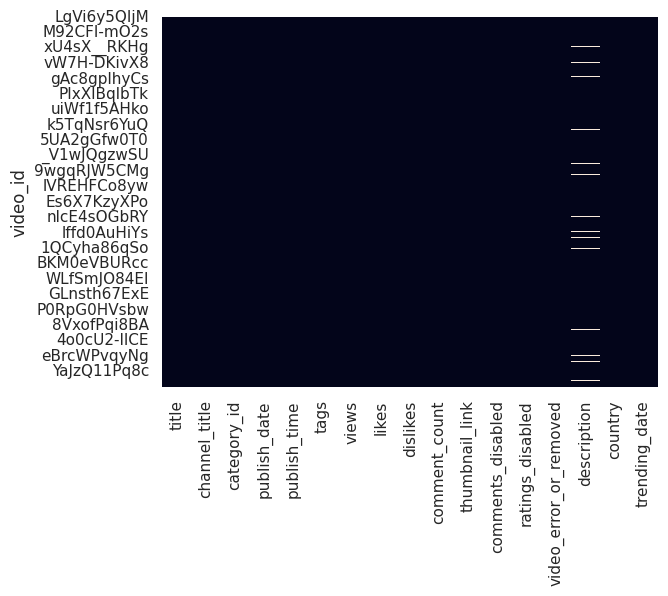

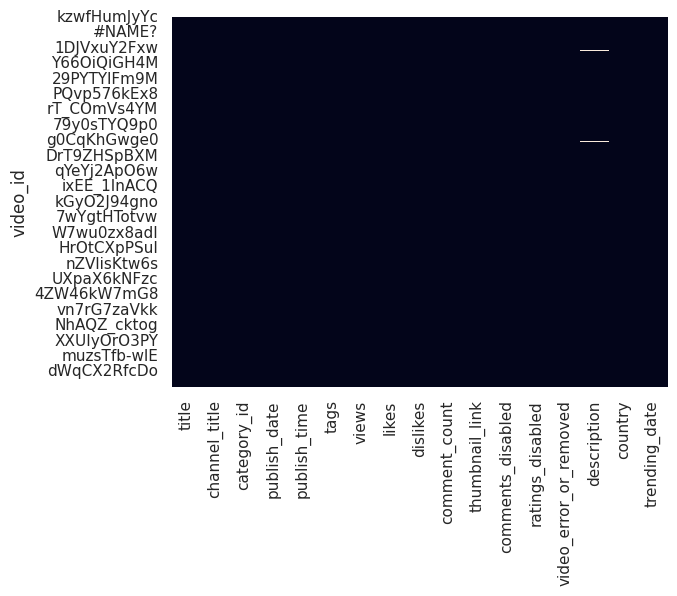

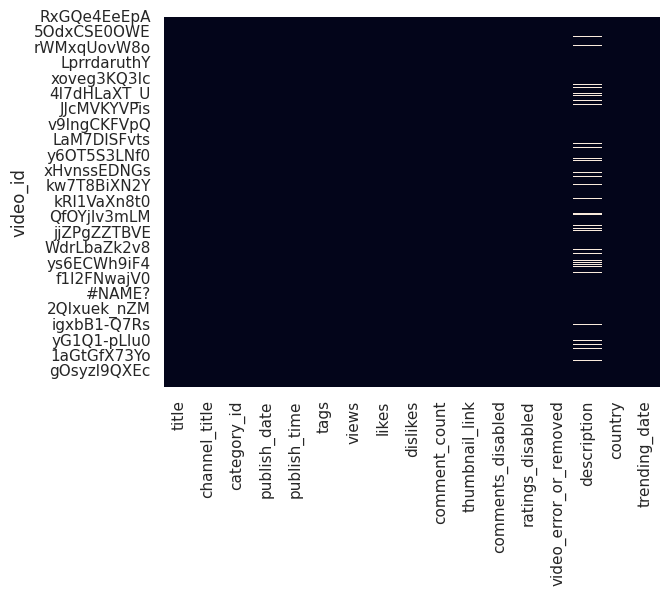

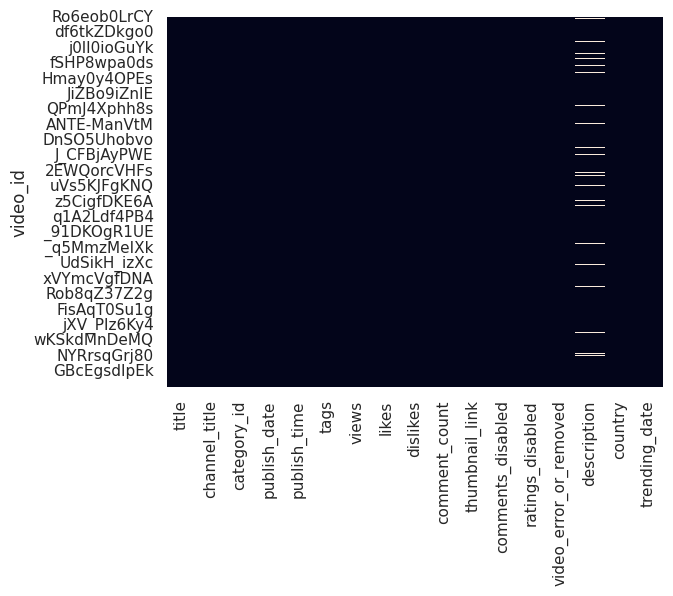

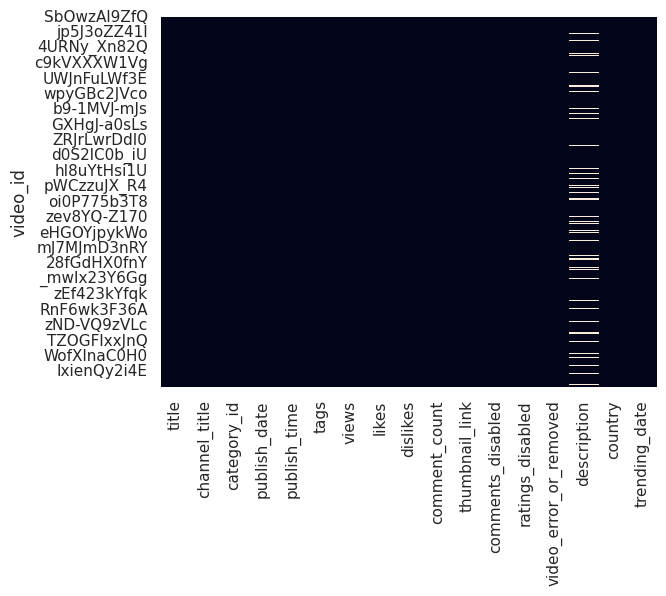

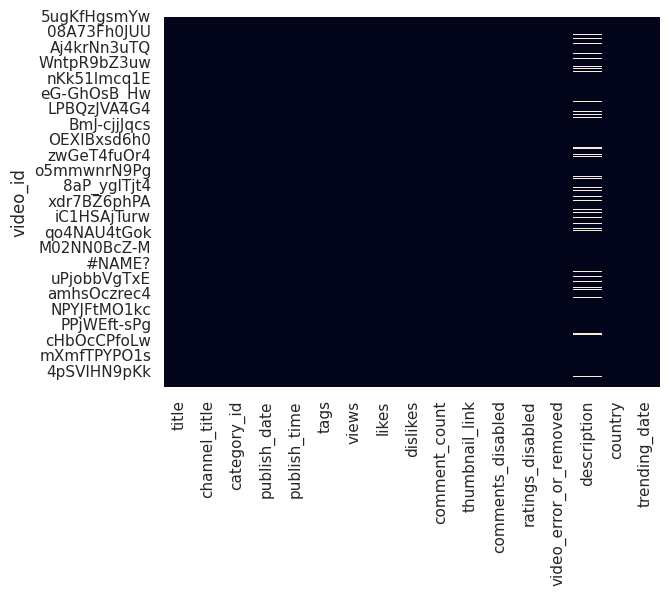

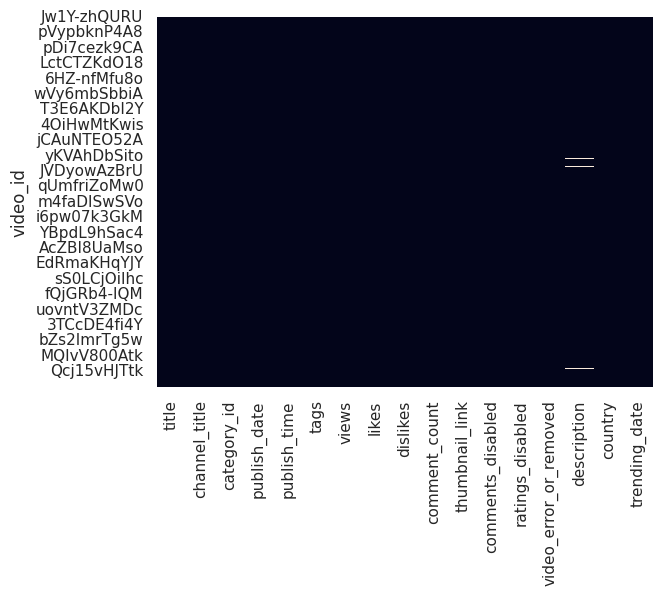

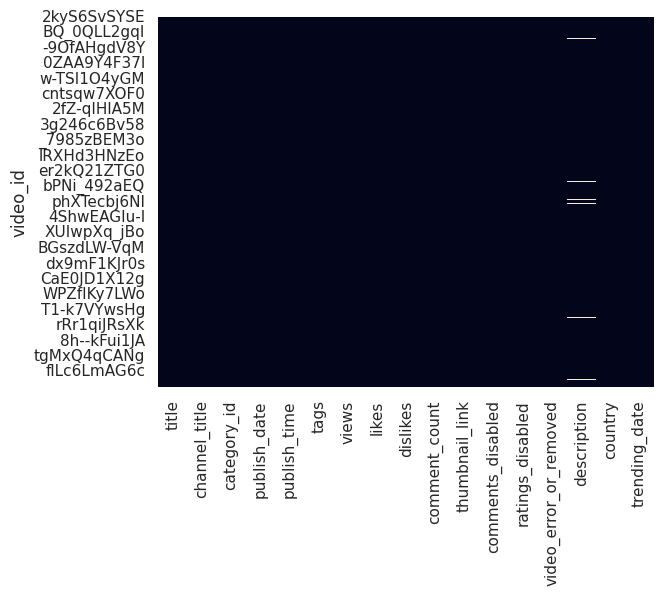

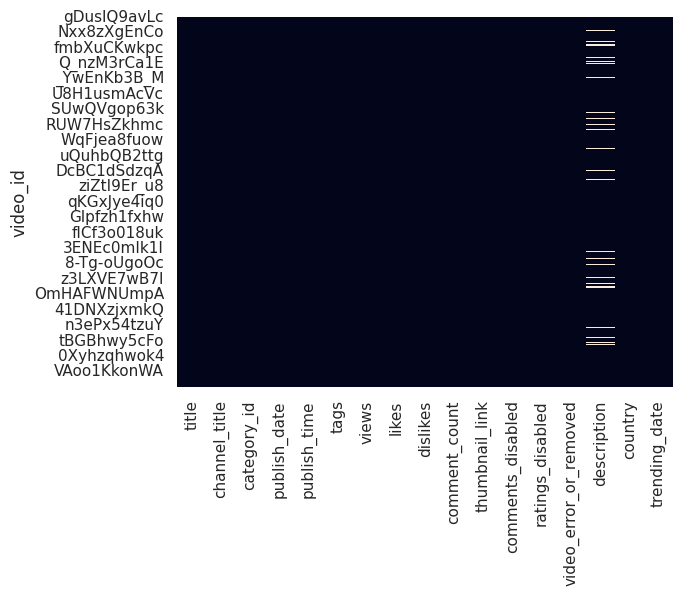

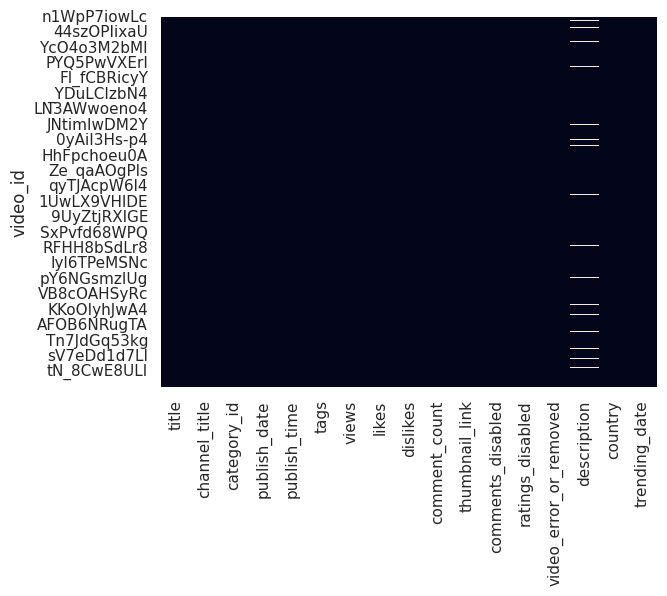

<Figure size 640x480 with 0 Axes>

In [33]:
for df in all_dataframes:
    sns.heatmap(df.isnull(), cbar=False)
    plt.figure()

We did this using a heat-map, where any missing value in a column would appears as an orange square against the black background of the heat-map. As you can see from one of the screenshots from the notebook below, no data set had any missing values exept the description column, which is related to an encoding problem, thus there was no handling necessary.

#Combining Every Dataframe Into One Huge Dataframe

In [56]:
combined_df = pd.concat(all_dataframes)

##Created a duplicate copy of our data frame

In [57]:
# Making copy of original dataframe
backup_df = combined_df.reset_index().sort_values('trending_date', ascending=False).set_index('video_id')

# Sorting according to latest trending date while removing duplicates
combined_df = combined_df.reset_index().sort_values('trending_date', ascending=False).drop_duplicates('video_id', keep='first').set_index('video_id')

# Doing the same above operation for each of the individual dataframes in the list we created earlier
for df in all_dataframes:
  df = df.reset_index().sort_values('trending_date', ascending=False).drop_duplicates('video_id', keep='first').set_index('video_id')

# Printing results
combined_df[['publish_date','publish_time','trending_date', 'country']].head()

# It can be seen that latest publications and trending information is at the top now

,publish_date,publish_time,trending_date,country
video_id,,,,
POTgw38-m58,2018-06-13,16:00:03,2018-06-14,CA
ZWqClKiz4_I,2018-06-12,02:10:19,2018-06-14,GB
oTn329CjrRA,2018-06-11,17:28:35,2018-06-14,GB
VhQmTmqcEY0,2018-06-01,02:00:01,2018-06-14,GB
ek1ePFp-nBI,2018-06-08,14:00:03,2018-06-14,GB


#Inserting Category Column

One of our final steps for the data cleaning of the data sets was checking the JSON files that were available with the data sets. We needed to see whether or not these files contained any useful data. As there were multiple files, we decided to read two files at random, in order to check whether they contained the same data or were they all containing different data.

In [58]:
# read file
with open('US_category_id.json', 'r') as f: # reading one randomly selected json files to make sense of its contents
  data = f.read()

# parse file
obj = json.loads(data)

obj

{'kind': 'youtube#videoCategoryListResponse',
 'etag': '"m2yskBQFythfE4irbTIeOgYYfBU/S730Ilt-Fi-emsQJvJAAShlR6hM"',
 'items': [{'kind': 'youtube#videoCategory',
   'etag': '"m2yskBQFythfE4irbTIeOgYYfBU/Xy1mB4_yLrHy_BmKmPBggty2mZQ"',
   'id': '1',
   'snippet': {'channelId': 'UCBR8-60-B28hp2BmDPdntcQ',
    'title': 'Film & Animation',
    'assignable': True}},
  {'kind': 'youtube#videoCategory',
   'etag': '"m2yskBQFythfE4irbTIeOgYYfBU/UZ1oLIIz2dxIhO45ZTFR3a3NyTA"',
   'id': '2',
   'snippet': {'channelId': 'UCBR8-60-B28hp2BmDPdntcQ',
    'title': 'Autos & Vehicles',
    'assignable': True}},
  {'kind': 'youtube#videoCategory',
   'etag': '"m2yskBQFythfE4irbTIeOgYYfBU/nqRIq97-xe5XRZTxbknKFVe5Lmg"',
   'id': '10',
   'snippet': {'channelId': 'UCBR8-60-B28hp2BmDPdntcQ',
    'title': 'Music',
    'assignable': True}},
  {'kind': 'youtube#videoCategory',
   'etag': '"m2yskBQFythfE4irbTIeOgYYfBU/HwXKamM1Q20q9BN-oBJavSGkfDI"',
   'id': '15',
   'snippet': {'channelId': 'UCBR8-60-B28hp2BmDPdnt

One of the other randomly selected JSON file had similar data. Each of the JSON file contains id ranging from 1 to 44 (both inclusive). And with each id is given its category and other information related to title, kind etc. Hence, we can use any one of the JSON files to map category to category id in our data frame.

In [62]:
category_id = {}

with open('DE_category_id.json', 'r') as f:
  d = json.load(f)
  for category in d['items']:
    category_id[category['id']] = category['snippet']['title']

combined_df.insert(2, 'category',
combined_df['category_id'].map(category_id))
backup_df.insert(2, 'category',
backup_df['category_id'].map(category_id))

for df in all_dataframes:
  df.insert(2, 'category', df['category_id'].map(category_id))

combined_df.head()

,index,title,category,channel_title,category_id,publish_date,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,country,trending_date
video_id,,,,,,,,,,,,,,,,,,,
POTgw38-m58,40880,ãå®æ´çãéå°æææ äººè©²æéº¼è¾¦ï...,Entertainment,ææå°ææå¤§è·ç­,24,2018-06-13,16:00:03,"å³å®æ²|""å³å§å""|""å°ææå¤§è·ç­""|""Sa...",107392,300,62,251,https://i.ytimg.com/vi/POTgw38-m58/default.jpg,False,False,False,èäººï¼æå¦ç¾ãçå ãç­åãLaLaã...,CA,2018-06-14
ZWqClKiz4_I,38770,"President Trump's Doctrine: We're America, Bit...",Comedy,The Opposition w/ Jordan Klepper,23,2018-06-12,02:10:19,"The Opposition with Jordan Klepper|""The Opposi...",105505,2004,131,227,https://i.ytimg.com/vi/ZWqClKiz4_I/default.jpg,False,False,False,The MSM criticizes President Trump's approach ...,GB,2018-06-14
oTn329CjrRA,38780,LeBron James and Draymond Green Face Off in NB...,Sports,UNINTERRUPTED,17,2018-06-11,17:28:35,"UNINTERRUPTED|""lebron james""|""cleveland cavali...",129026,1638,29,275,https://i.ytimg.com/vi/oTn329CjrRA/default.jpg,False,False,False,The Cavs and Warriors stars' routines for the ...,GB,2018-06-14
VhQmTmqcEY0,38779,Juanes - Pa Dentro,Music,JuanesVEVO,10,2018-06-01,02:00:01,"Juanes|""Pa""|""Dentro""|""Universal""|""Music""|""Lati...",21853809,78212,5701,4780,https://i.ytimg.com/vi/VhQmTmqcEY0/default.jpg,False,False,False,Music video by Juanes performing Pa Dentro. Â©...,GB,2018-06-14
ek1ePFp-nBI,38778,Halloween - Official Trailer (HD),Entertainment,Universal Pictures,24,2018-06-08,14:00:03,"halloween|""horror""|""horror movie""|""scary movie...",12955997,200539,7647,35147,https://i.ytimg.com/vi/ek1ePFp-nBI/default.jpg,False,False,False,"This October, Michael Myers returns. Watch the...",GB,2018-06-14


In [67]:
combined_df['category'].unique()

array(['Entertainment', 'Comedy', 'Sports', 'Music', 'Gaming',
       'News & Politics', 'Film & Animation', 'Education',
       'Howto & Style', 'People & Blogs', 'Travel & Events',
       'Autos & Vehicles', 'Pets & Animals', 'Shows', nan,
       'Science & Technology', 'Movies', 'Trailers'], dtype=object)

Thus, we cleaned up and refined our data sets into a finalized data frame, ready to be used for the upcoming EDA section of the project. We pickled both the finalized data frame and a copy of the original cleaned data frame into files, ready for use.

#Exploratory Data Analysis

##Ratio of likes-dislikes in different categories

<Axes: xlabel='ratio', ylabel='category'>

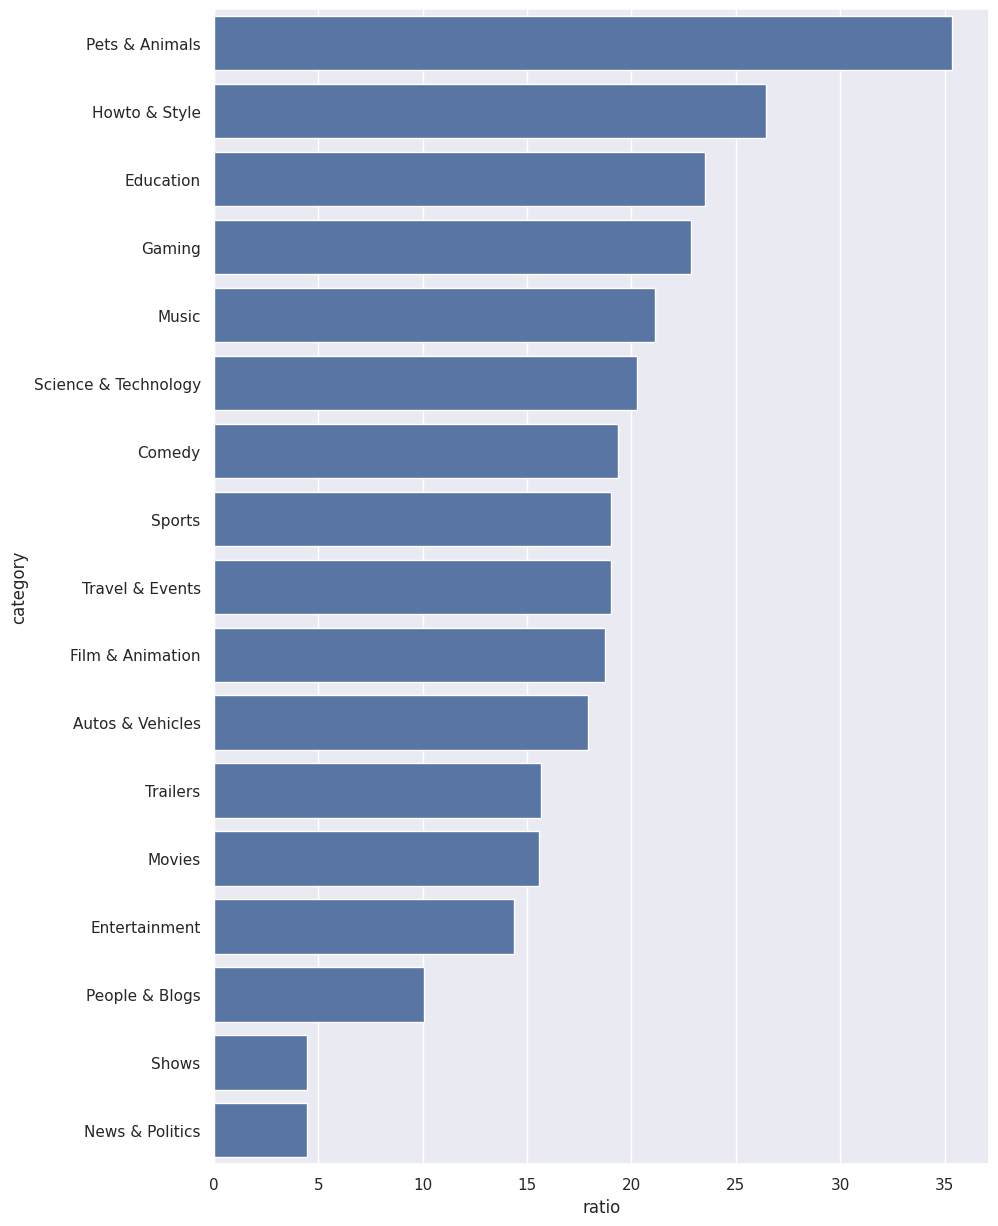

In [70]:
# calculating total likes for each category
likesdf = combined_df.groupby('category')['likes'].agg('sum')

# calculating total dislikes for each category
dislikesdf = combined_df.groupby('category')['dislikes'].agg('sum')

# calculating ratios of likes to dislikes
ratiodf = likesdf/dislikesdf

# most liked category to appear on top
ratiodf = ratiodf.sort_values(ascending=False).reset_index()

# plotting bar chart
ratiodf.columns = ['category','ratio']
plt.subplots(figsize=(10, 15))
sns.barplot(x="ratio", y="category", data=ratiodf,
            label="Likes-Dislikes Ratio", color="b")

##Observations:

*We see that videos belonging to the pets and animals categories have the highest ratio of likes to dislikes videos among the trending categories whereas new and politics videos have the least. From this we can infer that people are less divided on the content of videos based on entertainment than compared to topics such as new, whose content can lead to a division of opinions among the user.*

#Users like videos from which category more?

Next, we moved on to observe which categories were more preferred by the users, based on the likes on the videos in each category. Three of the outputs were randomly selected from the ten plotted graphs and results are as follows:

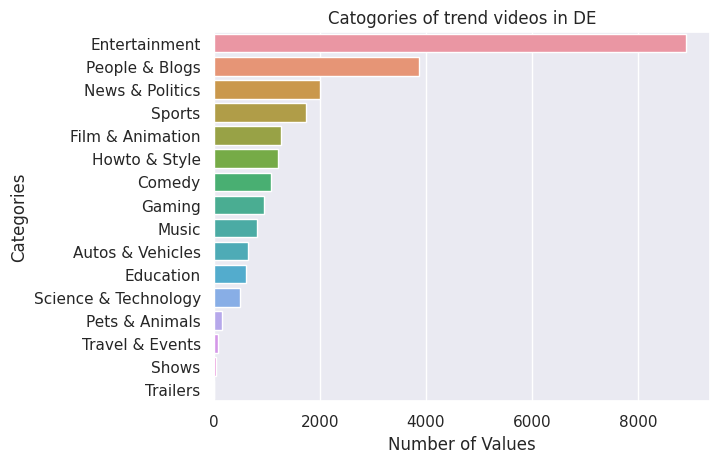

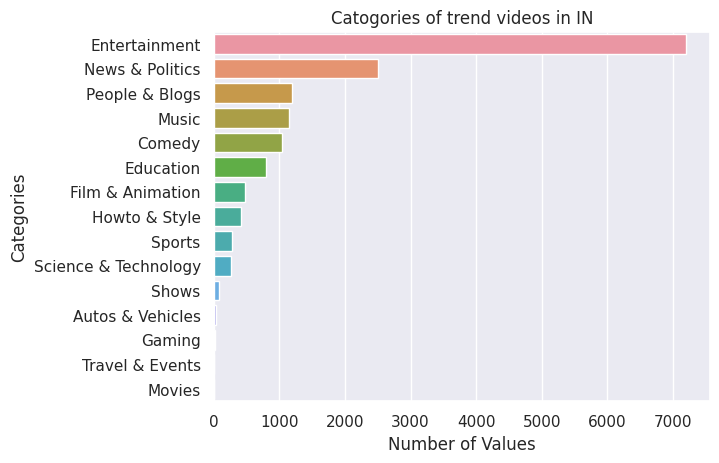

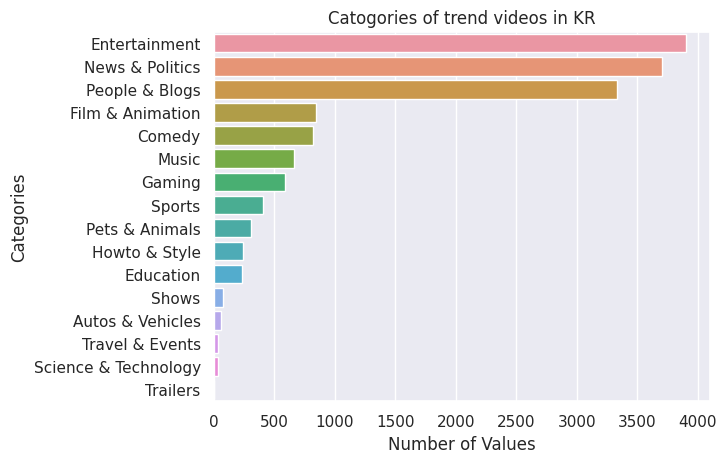

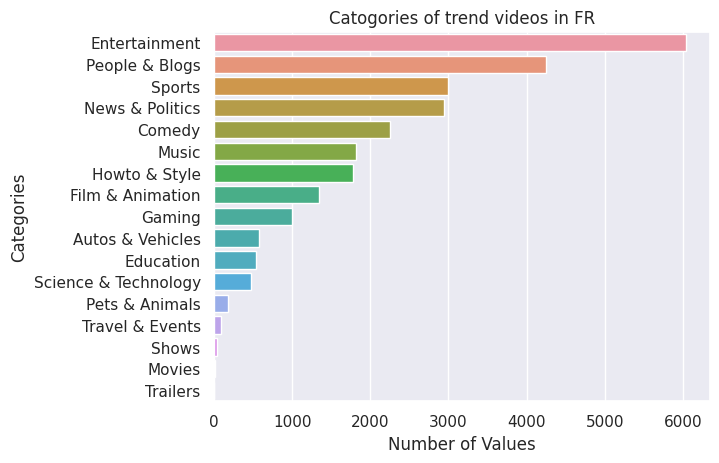

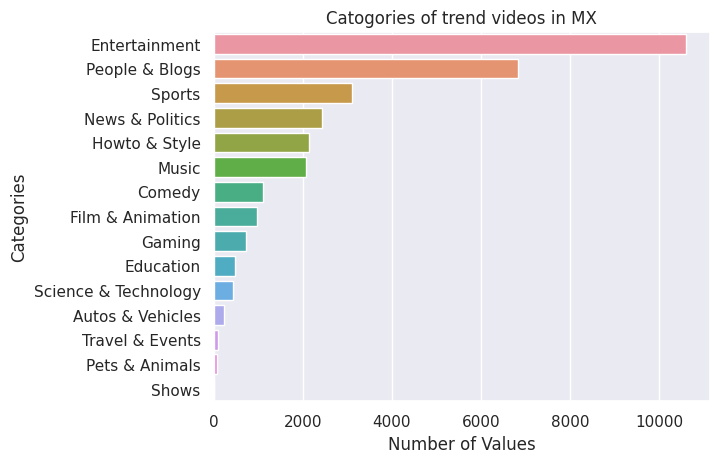

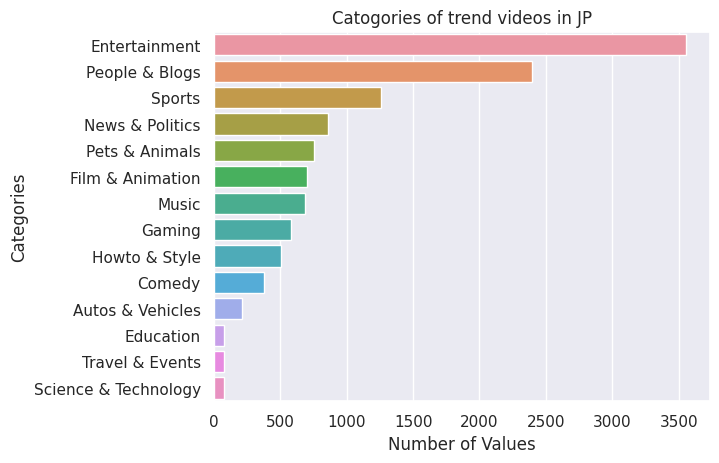

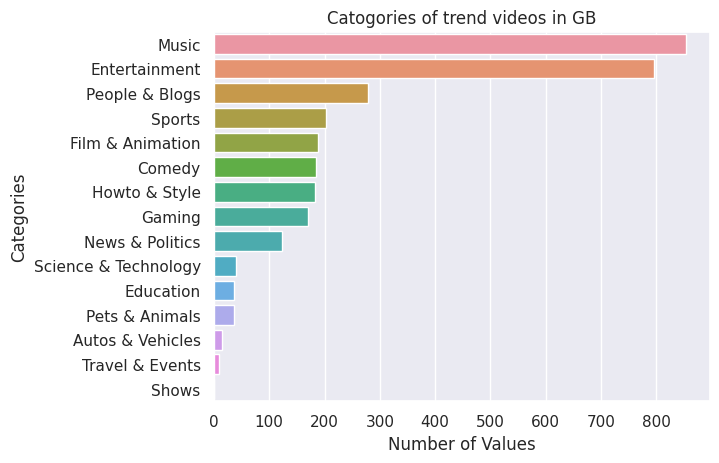

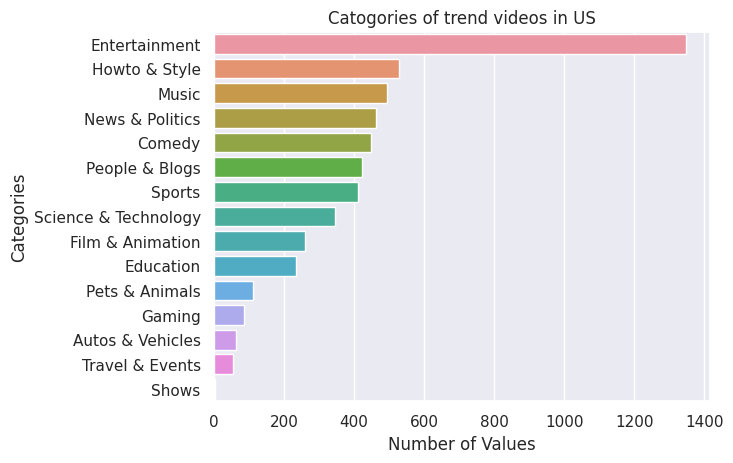

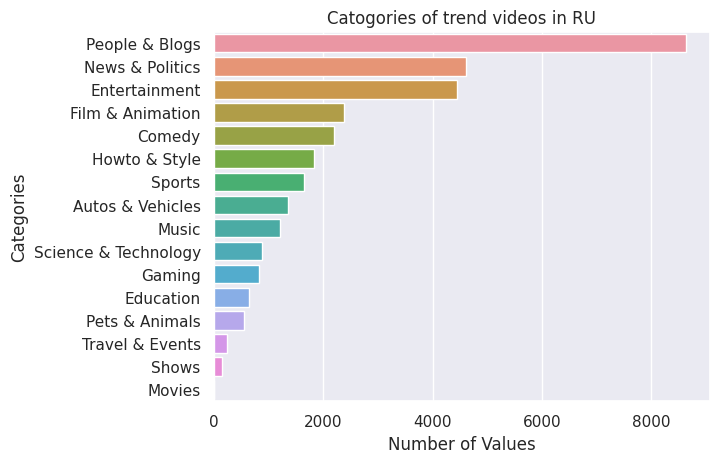

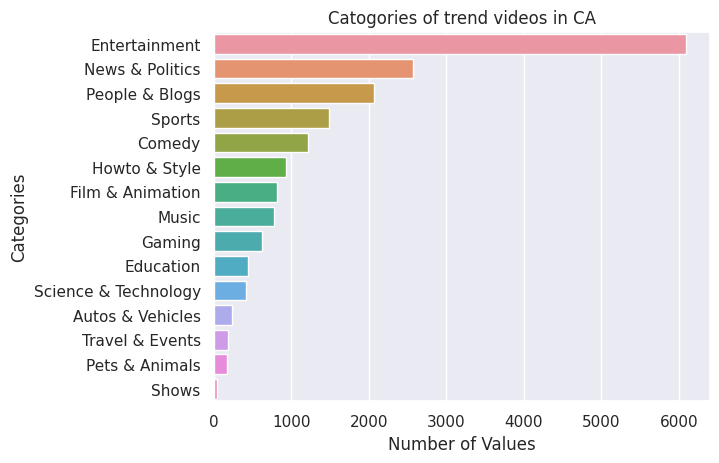

In [81]:
# Getting names of all countries
countries = []
allcsv = [i for i in glob.glob('*.{}'.format('csv'))]
for csv in allcsv:
  c = csv[0:2]
  countries.append(c)

for country in countries:
  tempdf = combined_df[combined_df['country'] == country]['category'].value_counts().reset_index()
  ax = sns.barplot(y=tempdf['index'], x =tempdf['category'], data=tempdf, orient='h')
  plt.figure
  plt.xlabel("Number of Values")
  plt.ylabel("Categories")
  plt.title("Catogories of trend videos in " + country)
  plt.show()

##Observations

Apart from RU and GB, category most liked by the users in each of the other countries is ‘Entertainment’.

Viewers from RU prefer the category ‘People and Blogs’ the most.

Viewers from GB prefer the category ‘Music’ the most.

Categories ‘Shows’, ‘Movies’, and ‘Trailers’ were the least liked ones in almost all of the countries.

##Top 5 videos that are on trending in each country?
Now, as we know the most preferred category from user in each country, we decided to see what were the top 5 videos on the trending page from each country. As done earlier, we selected 3 random results out of a total of 10 results to be displayed in our article and they are as follows:

In [86]:
temporary = []
for df in all_dataframes:
  temp = df
  temp = temp.reset_index().sort_values(by = ['views'], ascending=False)
  temp.drop_duplicates(subset='video_id', keep='first', inplace=True)
  temp.set_index('video_id', inplace=True)
  temp = temp.head(5)
  temporary.append(temp)
# Printing randomly selected countries
temporary[2][['title', 'channel_title', 'category', 'views', 'likes']]

,title,channel_title,category,views,likes
video_id,,,,,
FlsCjmMhFmw,YouTube Rewind: The Shape of 2017 | #YouTubeRe...,YouTube Spotlight,Entertainment,125432237,2912710
6ZfuNTqbHE8,Marvel Studios' Avengers: Infinity War Officia...,Marvel Entertainment,Entertainment,89930713,2606663
u9Mv98Gr5pY,VENOM - Official Trailer (HD),Sony Pictures Entertainment,Entertainment,53822757,1250535
QwievZ1Tx-8,Marvel Studios' Avengers: Infinity War - Offic...,Marvel Entertainment,Entertainment,45064699,1494997
rRr1qiJRsXk,Sanju | Official Teaser | Ranbir Kapoor | Rajk...,FoxStarHindi,Entertainment,44171797,780895


##Observations

*Users from every country mostly prefer videos belonging to the categories of ‘Music’ and ‘Entertainment’, potentially meaning users usually use the platform for recreational purposes in comparisons to other uses.*

##Is the most liked video also the most trending video?
Knowing the preference by country for the trending videos, a question arose: Is the most trending video in that country also the video with the most likes?

In [89]:
temporary = [] # to store results for each country
for df in all_dataframes:
  temp = df
  temp = temp.reset_index().sort_values(by = ['likes'], ascending=False)
  temp.drop_duplicates(subset='video_id', keep='first', inplace=True)
  temp.set_index('video_id', inplace=True)
  temp = temp.head(5) # top 5 that are most liked
  temporary.append(temp)

# Printing 3 randomly selected results
temporary[2][['views', 'likes']]

,views,likes
video_id,,
7C2z4GqqS5E,73463137,4924056
FlsCjmMhFmw,113876217,2811217
6ZfuNTqbHE8,80360459,2513103
VYOjWnS4cMY,73432600,2478908
kTlv5_Bs8aw,24628712,2454901


##Observation

*Although it may not seem easily visible, we concluded that most liked video is not the most trending one. This was further proven when we continued deeper into the data set and supporting information, we came to the conclusion that the most trending video is often the most viewed video (in combination with several other factors).*

##Maximum number of days to trending status for a video?
We know that all the videos available in the data sets are part of the trending page but how long did it take for a video, on average, to reach the trending page starting from the day the video was published?

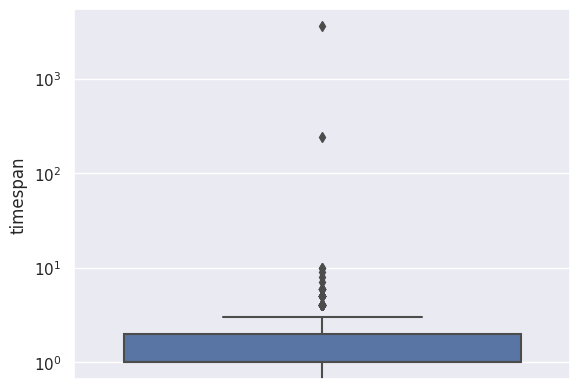

<ipython-input-113-088942ace9b6>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  _ = sns.distplot(to_trending.value_counts(),bins='rice',kde=False)


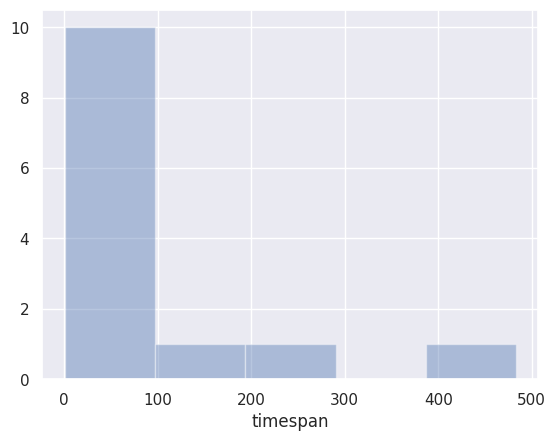

In [113]:
# Calculating days between publish and trending date
temporary = []
for data in all_dataframes:
    temp = data
    temp['timespan'] = (temp['trending_date'] - temp['publish_date']).dt.days
    temporary.append(temp)
# Plotting
to_trending = temporary[9].sample(1000).groupby('video_id').timespan.max() # CA
sns_ax = sns.boxplot(y = to_trending)
_ = sns_ax.set(yscale = "log")
plt.show()
_ = sns.distplot(to_trending.value_counts(),bins='rice',kde=False)


##Observation

*As we can see from both plots above, most videos take less a 100 days to reach the trending page. This can be attributed to viral natural of content on the internet, that if some online content is popular, it will often be shared and viewed within it’s short time span of relevancy.*

##Users like videos from which category more?
We also decided to check which category overall had the most likes from all the categories.

In [115]:
temp = combined_df
temp = temp.groupby('category')['views', 'likes'].apply(lambda x: x.astype(int).sum())
temp = temp.sort_values(by='likes', ascending=False).head()
temp

<ipython-input-115-77f7060752ca>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  temp = temp.groupby('category')['views', 'likes'].apply(lambda x: x.astype(int).sum())


,views,likes
category,,
Entertainment,17587554511,471868506
Music,18175187026,444810313
Comedy,4577351385,219096198
People & Blogs,5606737517,157767499
Howto & Style,2215631569,77250721


##Observation

*As we can see, most liked category is ‘Entertainment’ for all countries. This shows user preference to use YouTube as an entertainment platform.*

##Users comment on which category the most?
Similarly we decided to explore which category overall gets the most comments.

In [116]:
temp = combined_df
temp = temp.groupby('category')['likes', 'views', 'comment_count'].apply(lambda x: x.astype(int).sum())
temp = temp.sort_values(by='comment_count', ascending=False).head()
temp

<ipython-input-116-ebf254991f0b>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  temp = temp.groupby('category')['likes', 'views', 'comment_count'].apply(lambda x: x.astype(int).sum())


,likes,views,comment_count
category,,,
Entertainment,471868506,17587554511,68369779
Music,444810313,18175187026,36232002
People & Blogs,157767499,5606737517,24662982
Comedy,219096198,4577351385,23326457
News & Politics,53467984,3470696577,14956901


##Correlation between views, likes, dislikes, and comments
Next, we decided to see whether or there was any correlation between views, likes, dislikes, and comments.

In [117]:
col = ['views', 'likes', 'dislikes', 'comment_count']
corr = combined_df[col].corr()
corr

,views,likes,dislikes,comment_count
views,1.000000,0.768309,0.378175,0.423581
likes,0.768309,1.000000,0.435378,0.700536
dislikes,0.378175,0.435378,1.000000,0.667465
comment_count,0.423581,0.700536,0.667465,1.000000


import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(corr, *['views'], **{})
chart

import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(corr, *['likes'], **{})
chart

import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(corr, *['dislikes'], **{})
chart

import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(corr, *['comment_count'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(corr, *['views'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(corr, *['likes'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(corr, *['dislikes'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(corr, *['comment_count'], **{})
chart

import numpy as np
from google.colab import autoviz

def scatter_plots(df, colname_pairs, figscale=1, alpha=.8):
  from matplotlib import pyplot as plt
  plt.figure(figsize=(len(colname_pairs) * 10 * figscale, 10 * figscale))
  for plot_i, (x_colname, y_colname) in enumerate(colname_pairs, start=1):
    ax = plt.subplot(1, len(colname_pairs), plot_i)
    df.plot(kind='scatter', x=x_colname, y=y_colname, s=(32 * figscale), alpha=alpha, ax=ax)
    ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = scatter_plots(corr, *[[['views', 'likes'], ['likes', 'dislikes'], ['dislikes', 'comment_count']]], **{})
chart

##Observation

We can see from the results, there is a positive relation between views and likes, likes and comment_count, dislikes and comment_count. We came to this conclusion as anytime the correlation coefficient, denoted as corr, is greater than zero, it’s a positive relationship.

#The End